Pairs Trading in Crytpo, Event Driven Backtesting and Evaluation

In [ ]:
import warnings
warnings.filterwarnings('ignore')

1. Data processing & EDA

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import datetime
import os
import shutil
from decimal import Decimal
import fsspec
import pandas as pd

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/tencars/392-crypto-currency-pairs-at-minute-resolution")

Skipping, found downloaded files in "./392-crypto-currency-pairs-at-minute-resolution" (use force=True to force download)


In [ ]:
DATA_DIR = "./392-crypto-currency-pairs-at-minute-resolution"
fs = fsspec.filesystem('file')
raw_files = fs.glob(f"{DATA_DIR}/*.csv")
assert raw_files, f"Unable to find any histdata files in directory {DATA_DIR}"

I found that CSV file with "_usd.csv" is the relatively latest spot price data, so I will use spot price data for correlation calculation and long/short portfolio calculation

In [ ]:
spot = [link for link in raw_files if link.endswith('_usd.csv') ] # for correlation calculation

I see the time interval in these files concentrate from 2023-06-03 12:00:00 to 2023-06-11 12:00:00, so I will use interval 2023-06-03 12:00:00 => 2023-06-09 12:00:00 of the data for correlation calculation and interval 2023-06-09 12:00:00 => 2023-06-11 12:00:00 for backtesting

In [ ]:
#use multi threading to read all the csv files with file path array spot to pandas dataframe, with index as datetime, symbol as column name and close price as value, and then concatenate all the dataframes into one dataframe

import os
import pandas as pd
from tqdm import tqdm
from typing import List
import dask.dataframe as dd
import multiprocessing

def read_csv_to_df(file_path: str) -> pd.DataFrame:
  df = pd.read_csv(file_path, index_col = 'time')
  df = df[['close']]
  df.columns = [file_path.split('/')[-1].replace(".csv","")]
  df.index = pd.to_datetime(df.index, unit='ms')

  # assume df is a dataframe with a datetime index
  start_time = '2023-06-03 12:00:00'
  end_time = '2023-06-11 12:00:00'
  # create a new datetime index at 5-minute intervals
  new_index = pd.date_range(start=start_time, end=end_time, freq='5T')
  # resample the dataframe to the new index
  df_resampled = df.resample('5T').last().reindex(new_index)
  # fill missing values with the last observed value
  df_resampled.fillna(method='ffill', inplace=True)

  return df_resampled

def read_csvs_to_df(file_paths: List[str]) -> pd.DataFrame:
    with multiprocessing.Pool() as pool:
        dfs = list(tqdm(pool.map(read_csv_to_df, file_paths), total=len(file_paths)))
    return dfs

temp = read_csvs_to_df(spot)

spot_df = dd.concat(temp, axis=1).compute()


100%|██████████| 67/67 [00:00<00:00, 370736.63it/s]


In [ ]:
# count the number of missing values in each column
na_counts = spot_df.isna().sum()

# drop columns with more than 0 NaN value
spot_df = spot_df.drop(columns=na_counts[na_counts >= 1].index)

In [ ]:
start_time = '2023-06-03 12:00:00'
end_time = '2023-06-09 12:00:00'

# Convert the start_time and end_time strings to datetime objects
start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

# Use boolean indexing to slice the DataFrame
spot_df_corr_test = spot_df[(spot_df.index >= start_time) & (spot_df.index <= end_time)]

2. Hypothesis + Rationale

My strategy is to do pair trading on the above 4 pairs with z-score of OLS spread as an indicator, I come up with below strategy detail based on historical data with same time horizon as cointegration test.

Intuitively, rolling normalized spread of other/chsb will be wider in range than below table/graph, so the criteria for pairs trading in this project will be:
1. if 100 minutes' rolling normalized spread > +1.5, short other/chsb pair, i.e. short sell other and buy chsb, both using 50% of the total capital
2. if 100 minutes' rolling normalized spread < -1.5, long other/chsb pair, i.e. buy other and short sell chsb, both using 50% of the total capital
3. if 100 minutes' rolling normalized spread is between -1.2 and +1.2, hold the current portfolio.

In [ ]:
import statsmodels.api as sm

def zscore(series):
    return (series - series.mean()) / np.std(series)

def spread_calculation(selected_spot_df_corr_test,final_pairs):
    all_spreads = pd.DataFrame()
    for (chsb,other) in final_pairs:
        S1 = selected_spot_df_corr_test[chsb]
        S2 = selected_spot_df_corr_test[other]
        X = sm.add_constant(S1)
        result = (sm.OLS(S2,X)).fit()
        b = result.params[chsb]
        c = result.params['const']
        spread = S2 - (b*S1 + c)
        all_spreads[other] = zscore(spread)
    #calculate average spread as the spread of the portfolio
    all_spreads['avg_spread'] = all_spreads.mean(axis=1)
    return all_spreads

all_spreads = spread_calculation(spot_df_corr_test,final_pairs)

In [ ]:
all_spreads

,ethw_usd,shib_usd,spell_usd,sushi_usd,avg_spread
2023-06-03 12:00:00,0.220943,1.939247,1.300132,1.745772,1.301523
2023-06-03 12:05:00,-0.543129,1.146944,0.576759,0.817940,0.499629
2023-06-03 12:10:00,-0.543129,1.146944,0.576759,0.804348,0.496230
2023-06-03 12:15:00,-0.543129,1.146944,0.576759,0.837094,0.504417
2023-06-03 12:20:00,-0.543129,1.146944,0.576759,0.837094,0.504417
...,...,...,...,...,...
2023-06-09 11:40:00,0.651765,0.094772,-0.062825,0.851615,0.383832
2023-06-09 11:45:00,0.651765,0.094772,0.032848,0.914636,0.423505
2023-06-09 11:50:00,0.498951,0.029593,-0.111826,0.729069,0.286447
2023-06-09 11:55:00,0.648989,0.029593,-0.111826,0.926162,0.373229


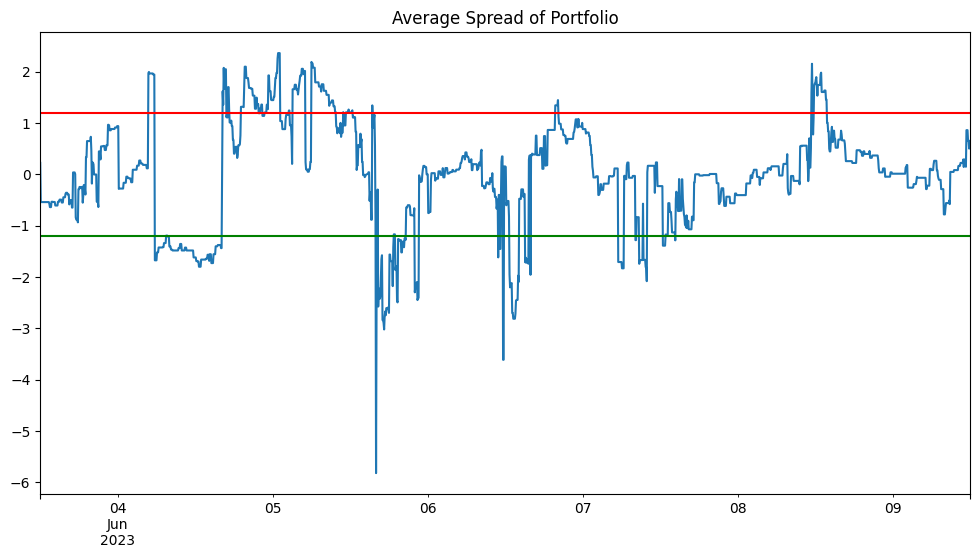

In [ ]:
#plot the avg_spread of the portfolio
all_spreads['ethw_usd'].plot(figsize=(12,6))
plt.axhline(1.2, color='red')
plt.axhline(-1.2, color='green')
plt.title("Average Spread of Portfolio")
plt.show()

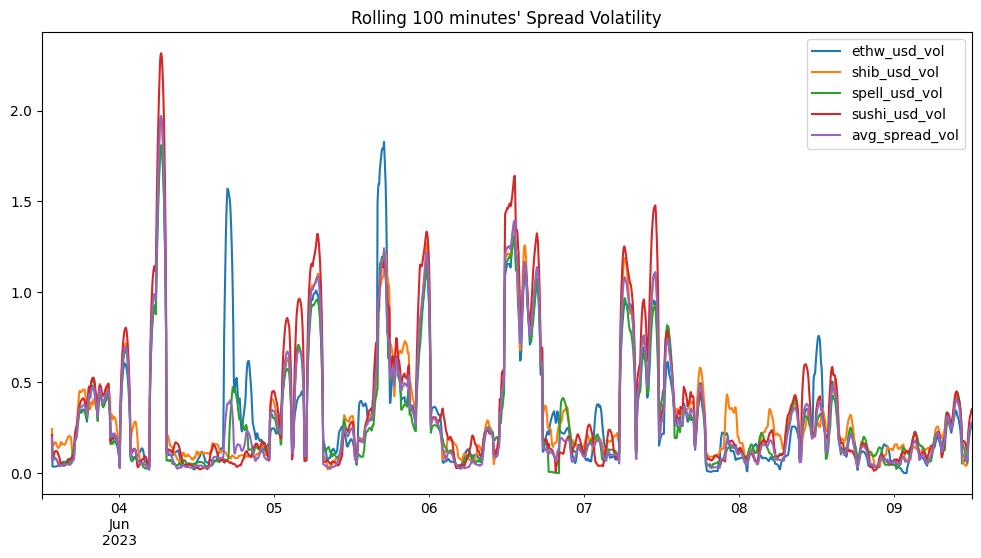

ethw_usd_vol 0.3300980699981749
shib_usd_vol 0.34890805479547093
spell_usd_vol 0.3033515735913845
sushi_usd_vol 0.3589677608990809
avg_spread_vol 0.31091793031892345


In [ ]:
#calculate volatility of all_spreads, for each column individually in rolling window of 20
for column in all_spreads.columns:
    all_spreads[column+'_vol'] = all_spreads[column].rolling(20).std()

#plot the volatility of the portfolio
for column in all_spreads.columns:
    if '_vol' in column:
        all_spreads[column].plot(figsize=(12,6),label=column)
plt.legend()
plt.title("Rolling 100 minutes' Spread Volatility")
plt.show()

#print average volatility of the portfolio
for column in all_spreads.columns:
    if '_vol' in column:
        print(column,all_spreads[column].mean())


As ethw, shib, spell and sushi are also highly correlated to each other, to reduce transaction cost, our final trading pair is spell/chsb because the spread has lowest rolling average volatility, which is good for pairs trading.

Event Driven Backtesting using backtrader library

In [ ]:
!pip install backtrader && pip install pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import backtrader as bt
import backtrader.indicators as btind
import pyfolio as pf

Make data0 = spell, and data1 = chsb

In [ ]:
trading_pair = ['spell_usd', 'chsb_usd']

Below is the back-tester with documentation in the coding, using the criteria for pairs trading mentioned above

In [ ]:
class PairTradingStrategy(bt.Strategy):
    params = dict(
        period=20,
        stake=10,
        qty1=0,
        qty2=0,
        printout=True,
        upper=1.5,
        lower=-1.5,
        status=0,
        portfolio_value=10000
    )

    def log(self, txt, dt=None):
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = None

    def __init__(self):
        # To control operation entries
        self.orderid = None
        self.qty1 = self.p.qty1
        self.qty2 = self.p.qty2
        self.upper_limit = self.p.upper
        self.lower_limit = self.p.lower
        self.status = self.p.status
        self.portfolio_value = self.p.portfolio_value

        # Signals performed with PD.OLS :
        if len(self.data0.close.get(size=self.p.period)) <20:
            self.transform = btind.OLS_TransformationN(self.data0, self.data1,period=len(self.data0.close.get(size=self.p.period)))
            self.zscore = self.transform.zscore
        else:
            self.transform = btind.OLS_TransformationN(self.data0, self.data1,period=self.p.period)
            self.zscore = self.transform.zscore


        #self.transform = btind.OLS_TransformationN(self.data0, self.data1,period=self.p.period)
        #self.zscore = self.transform.zscore
        #self.zscore = [0]



    def next(self):

        if self.orderid:
            return  # if an order is active, no new orders are allowed

        # Simply debug message
        if self.p.printout:
            print('Self  len:', len(self))
            print('Data0 len:', len(self.data0))
            print('Data1 len:', len(self.data1))
            print('Data0 type:', type(self.data0.close))
            print('Data0 get 20', len(self.data0.close.get(size=self.p.period)))

            print('Data0 len == Data1 len:',len(self.data0) == len(self.data1))
            print('Data0 dt:', self.data0.datetime.datetime())
            print('Data1 dt:', self.data1.datetime.datetime())
            print('status is', self.status)
            print('zscore is', self.zscore[0])

        # Step 2: Check conditions for SHORT & place the order
        # Checking the condition for SHORT
        if (self.zscore[0] > self.upper_limit) and (self.status != 1):

            # Calculating the number of shares for each coin
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for spell_usd
            y = int(value / (self.data1.close))  # Find the number of shares for chsb_usd

            # Placing the order
            self.sell(data=self.data0, size=(x + self.qty1)) # Place an order for selling x + qty1 shares spell_usd
            self.buy(data=self.data1, size=(y + self.qty2)) # Place an order for buying y + qty2 shares chsb_usd

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Coin1 is x shares
            self.qty2 = y  # The new open position quantity for Coin2 is y shares

            self.status = 1  # The current status is "short the spread"

            # Step 3: Check conditions for LONG & place the order
            # Checking the condition for LONG
        elif (self.zscore[0] < self.lower_limit) and (self.status != 2):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for NFLX
            y = int(value / (self.data1.close))  # Find the number of shares for META

            # Place the order
            self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares spell_usd
            self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares chsb_usd

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Coin1 is x shares
            self.qty2 = y  # The new open position quantity for Coin2 is y shares
            self.status = 2  # The current status is "long the spread"


    def stop(self):
        print('==================================================')
        print('Starting Value : %.2f' % self.broker.startingcash)
        print('Ending   Value : %.2f' % self.broker.getvalue())
        print('==================================================')



All backtest related arguments are stored in below class, with time horizon of 4 years, starting cash 10000 and trading commission fee of 0.5%

In [ ]:
class all_backtest_args:
    def __init__(self, trading_pair):
        #1st data into the system
        self.data0 = trading_pair[0]
        #2nd data into the system
        self.data1 = trading_pair[1]

    #Starting date in YYYY-MM-DD format
    fromdate = '2023-06-09 12:00:00'
    #To date in YYYY-MM-DD format
    todate = '2023-06-11 12:00:00'
    #Starting Cash
    cash = 10000
    #Percentage commission (0.005 is 0.5%)
    commperc = 0.005

Full backtesting process with documentation is shown below.

In [ ]:
args = all_backtest_args(trading_pair)

# Convert the start_time and end_time strings to datetime objects
start_time = pd.to_datetime(args.fromdate)
end_time = pd.to_datetime(args.todate)

# Use boolean indexing to slice the DataFrame
spot_df_back_test = spot_df[(spot_df.index >= start_time) & (spot_df.index <= end_time)]

# Create a cerebro
cerebro = bt.Cerebro()

# Create the 1st data
_data0 = spot_df_back_test[['spell_usd']]
_data0.columns = ['close']
_data0.to_csv("data0.csv")
data0 = bt.feeds.PandasData(dataname=_data0)


# Add the 1st data to cerebro
cerebro.adddata(data0)

# Create the 2nd data
_data1 = spot_df_back_test[['chsb_usd']]
_data1.columns = ['close']
_data1.to_csv("data1.csv")
data1 = bt.feeds.PandasData(dataname=_data1)

# Add the 2nd data to cerebro
cerebro.adddata(data1)

# Add the strategy
cerebro.addstrategy(PairTradingStrategy)

# Add pyfolio for calculating statistics and plotting backtesting graph
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Add the commission - only stocks like a for each operation
cerebro.broker.setcash(args.cash)

# Add the commission - only stocks like a for each operation
cerebro.broker.setcommission(commission=args.commperc)

In [ ]:
# Run the backtesting and analyze the backtesting reuslt
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Lastly I use pyfolio for evaluating the backtesting result with different metrics, and I also use backtrader's built-in function for presenting a snapshot of the trades throughout the time horizon

In [ ]:
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions
)

Snapshot of Trades Throughout the Time Horizon

In [ ]:
#presenting a snapshot of the trades throughout the time horizon
cerebro.plot()[0][0]